# ML Pipeline Example

In [1]:
# Imports
from ml_pipeline.preprocessing import transform_data, preprocess_data
from ml_pipeline.training import train_cross_validation
from ml_pipeline.evaluation import evaluate_models_bc, evaluate_models_regression
from ml_pipeline.shap_plots import calculate_shap_values, display_beeswarm, display_waterfall
from ml_pipeline.postprocessing import generate_prod_data
from ml_pipeline.model import ModelWrapper

import pandas as pd
import ezkl
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

import torch
import torch.nn as nn

from pathlib import Path
import json
import os

base_folder = Path("notebooks/")
data_folder = base_folder / "data/"
zkml_folder = base_folder / "zkml/"

data_folder.mkdir(parents=True, exist_ok=True)
zkml_folder.mkdir(parents=True, exist_ok=True)


## 1. Read data

In [2]:
df = pd.concat([pd.read_csv(data_folder / file) for file in ["df_base.csv", "df_layer_zero.csv", "df_zksync.csv"]])
df["old_target"] = df["target"]
df["target"] = df["target_reg"] < -0.99

In [3]:
df.head()

,month_start,User Address,Active Days,Active Months,Active Weeks,Amount of total transactions ($),Days since first activity,Days since last transaction,Interacted TX Contracts,Transactions Count,...,Active Weeks - past 3 windows,Active Weeks - past 6 windows,Trend Transactions - past 3 windows,Trend Transactions - past 6 windows,target_reg,Transaction Points Dollars,Transaction Points Count,Trend_Objetive_next_month,target,old_target
0,2023-09-01,0x00000000000007736e2f9aa5630b8c812e1f3fc9,5.0,1.0,2.0,294.78,8,8,9.0,11.0,...,0.0,0.0,0.0,0.0,NaN,1.0,1,1.0,False,NaN
1,2023-10-01,0x00000000000007736e2f9aa5630b8c812e1f3fc9,29.0,1.0,6.0,4025.27,39,30,145.0,166.0,...,0.0,0.0,0.0,0.0,NaN,2.0,1,1.0,False,NaN
2,2023-11-01,0x00000000000007736e2f9aa5630b8c812e1f3fc9,18.0,1.0,3.0,39937.99,69,29,355.0,427.0,...,0.0,0.0,0.0,0.0,NaN,3.0,1,NaN,False,NaN
3,2023-08-01,0x0000000000176704cb964c95af7e16a81e1fca6f,1.0,1.0,1.0,0.00,21,21,1.0,1.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,1,-1.0,True,1.0
4,2023-08-01,0x00000000002088951336d7972746a135f2956417,2.0,1.0,1.0,202.48,30,30,5.0,7.0,...,0.0,0.0,0.0,0.0,-1.0,1.0,1,-1.0,True,1.0


In [4]:
df.describe()

,Active Days,Active Months,Active Weeks,Amount of total transactions ($),Days since first activity,Days since last transaction,Interacted TX Contracts,Transactions Count,Transactions Count - past 3 windows,Transactions Count - past 6 windows,...,Active Months - past 6 windows,Active Weeks - past 3 windows,Active Weeks - past 6 windows,Trend Transactions - past 3 windows,Trend Transactions - past 6 windows,target_reg,Transaction Points Dollars,Transaction Points Count,Trend_Objetive_next_month,old_target
count,300000.000000,300000.0,300000.000000,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,...,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,156555.000000,299972.000000,300000.00000,268423.000000,156555.000000
mean,2.574903,1.0,1.758087,2.220771e+03,67.037473,17.951000,3.800497,11.136910,2.959253,0.507049,...,0.052518,0.554046,0.116988,0.169866,0.091384,-0.553575,0.956009,1.00053,-0.438810,0.580671
std,3.008087,0.0,1.100937,2.758481e+05,69.537674,8.880961,7.517537,282.935989,105.244520,3.242380,...,0.205896,1.081623,0.507358,3.120966,2.323528,0.402964,0.652579,0.02689,0.710741,0.493451
min,1.000000,1.0,1.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.999922,-0.991137,-1.000000,0.000000,1.00000,-1.000000,0.000000
25%,1.000000,1.0,1.000000,1.600000e-01,16.000000,11.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.984127,1.000000,1.00000,-1.000000,0.000000
50%,1.000000,1.0,1.000000,8.490000e+00,42.000000,19.000000,2.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.666667,1.000000,1.00000,-0.800000,1.000000
75%,3.000000,1.0,2.000000,1.224125e+02,99.000000,26.000000,4.000000,8.000000,1.000000,0.000000,...,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,1.000000
max,31.000000,1.0,6.000000,1.416631e+08,621.000000,31.000000,988.000000,73716.000000,53475.666667,314.833333,...,1.000000,5.333333,5.333333,503.000000,335.000000,0.000000,6.000000,4.00000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 99999
Data columns (total 30 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   month_start                                        300000 non-null  object 
 1   User Address                                       300000 non-null  object 
 2   Active Days                                        300000 non-null  float64
 3   Active Months                                      300000 non-null  float64
 4   Active Weeks                                       300000 non-null  float64
 5   Amount of total transactions ($)                   300000 non-null  float64
 6   Days since first activity                          300000 non-null  int64  
 7   Days since last transaction                        300000 non-null  int64  
 8   Interacted TX Contracts                            300000 non-null  float64
 9  

In [6]:
feature_renames ={
    "Active Days": "Days with activity",
    "Active Days - past 3 windows": "Days with activity in 3 windows",
    "Active Days - past 6 windows": "Days with activity in 6 windows",
    "Active Weeks": "Weeks with activity",
    "Active Weeks - past 3 windows": "Weeks with activity in 3 windows",
    "Active Weeks - past 6 windows": "Weeks with activity in 6 windows",
    "Active Months": "Months with activity",
    "Active Months - past 3 windows": "Months with activity in 3 windows",
    "Active Months - past 6 windows": "Months with activity in 6 windows",
    "Amount of total transactions ($)": "Transacted value",
    "Amount of total transactions ($) - past 3 windows": "Transacted value in 3 windows",
    "Amount of total transactions ($) - past 6 windows": "Transacted value in 6 windows",
    "Days since first activity": "Days since first activity",
    "Days since last transaction": "Days since last activity",
    "Interacted TX Contracts": "Interacted contracts",
    "Interacted TX Contracts - past 3 windows": "Interacted contracts in 3 windows",
    "Interacted TX Contracts - past 6 windows": "Interacted contracts in 6 windows",
    "Transactions Count": "Transactions",
    "Transactions Count - past 3 windows": "Transactions in 3 windows",
    "Transactions Count - past 6 windows": "Transactions in 6 windows",
    #"Trend_Objetive_next_month": "Transactions trend",
    "Trend Transactions - past 3 windows": "Transactions trend in 3 windows",
    "Trend Transactions - past 6 windows": "Transactions trend in 6 windows",
    "Transaction Points Dollars": "Transaction value tiers",
}

In [7]:
label_name_bc = "target"
label_name_ref = "target_reg"
holdout_month = "2023-09-01"

df = df.rename(columns=feature_renames)

df_to_ml = df[~df["month_start"].isin(["2023-09-01", "2023-10-01", "2023-11-01"])].fillna(0)
df_to_prod = df[df["month_start"].isin([holdout_month])]

feature_selection = [f for f in feature_renames.values()]

is_classification = True

## 2. Data preprocessing

In [8]:
(
    train_X, 
    train_y, 
    test_X, 
    test_y, 
    group_kfold_splits, 
    (scaler, mean, std),
    train_index_new_order,
    test_index_new_order,
) = preprocess_data(
    data=df_to_ml,
    label_col=label_name_bc if is_classification else label_name_ref,
    grouping_col="User Address",
    n_splits=5,
    test_size=0.1,
    feature_cols=feature_selection,
    do_feature_scaling=True,
    seed=1534,
    is_classification=is_classification,
)

Total elements: 156555
Test elements min: 15656

Final train elements: 140898 across 56948 groups
Final test elements: 15657 across 6355 groups
Label is target

Elements in each fold:
Fold 0: 112718 (45558 groups), 28180 (11390 groups)
Fold 1: 112718 (45558 groups), 28180 (11390 groups)
Fold 2: 112718 (45558 groups), 28180 (11390 groups)
Fold 3: 112719 (45559 groups), 28179 (11389 groups)
Fold 4: 112719 (45559 groups), 28179 (11389 groups)

GroupKFold splits hash: 05fa445da95275bbee89119706573164


## 3. Model definition & training

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(len(feature_renames), 40)  # First hidden layer
        self.fc2 = nn.Linear(40, 40) # Second hidden layer
        self.fc3 = nn.Linear(40, 40) # Third hidden layer
        self.output = nn.Linear(40, 1) # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output(x)
        return x

In [10]:
(
    models,
    train_loss_lists,
    train_accuracy_lists,
    valid_loss_lists,
    valid_accuracy_lists,
) = train_cross_validation(
    model_class=Model,
    train_X=train_X,
    train_y=train_y,
    group_kfold_splits=group_kfold_splits,
    batch_size=64,
    epochs=50,
    learning_rate=0.0001,
    shuffle_batches=False,
    is_classification=is_classification,
)


Fold 0
Epoch: 0 Train loss: 0.5109 Validation loss: 0.5120
Epoch: 10 Train loss: 0.4741 Validation loss: 0.4791
Epoch: 20 Train loss: 0.4703 Validation loss: 0.4760
Epoch: 30 Train loss: 0.4685 Validation loss: 0.4748
Epoch: 40 Train loss: 0.4675 Validation loss: 0.4743
Fold 0 done, metrics:
  Train loss: 0.4665
  Validation loss: 0.4736
  Train accuracy: 0.7787
  Validation accuracy: 0.7748

Fold 1
Epoch: 0 Train loss: 0.5049 Validation loss: 0.5092
Epoch: 10 Train loss: 0.4742 Validation loss: 0.4753
Epoch: 20 Train loss: 0.4711 Validation loss: 0.4725
Epoch: 30 Train loss: 0.4694 Validation loss: 0.4713
Epoch: 40 Train loss: 0.4685 Validation loss: 0.4710
Fold 1 done, metrics:
  Train loss: 0.4678
  Validation loss: 0.4707
  Train accuracy: 0.7786
  Validation accuracy: 0.7769

Fold 2
Epoch: 0 Train loss: 0.5014 Validation loss: 0.5008
Epoch: 10 Train loss: 0.4739 Validation loss: 0.4737
Epoch: 20 Train loss: 0.4708 Validation loss: 0.4710
Epoch: 30 Train loss: 0.4688 Validation lo

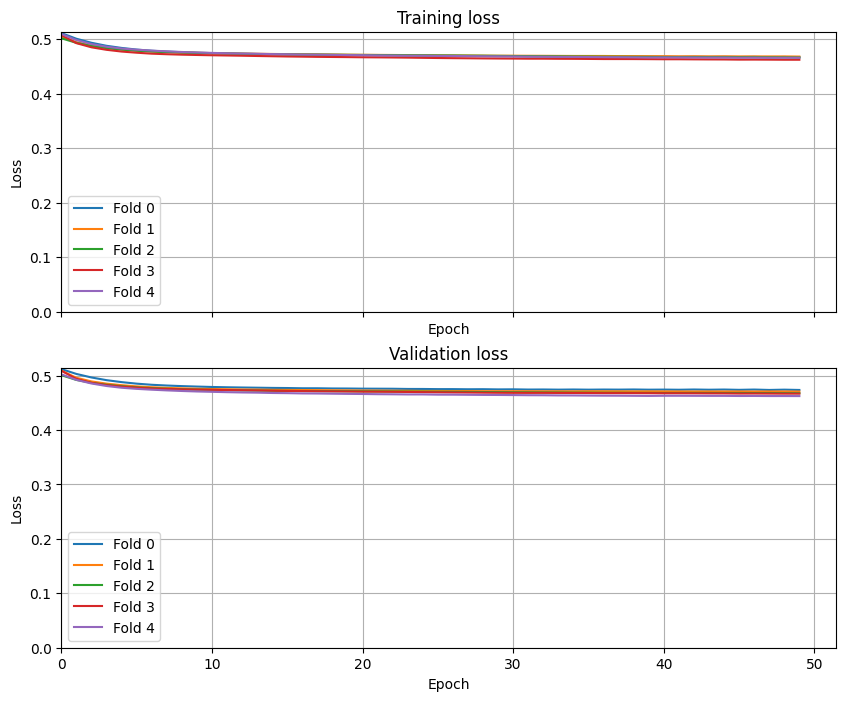

In [11]:
# Plot the loss evolution for all folds

# First the training loss
fig = plt.figure(figsize=(10, 8))
axes: list[Axes] = fig.subplots(2, 1, sharex=True)
ax = axes[0]
for i, train_loss_list in enumerate(train_loss_lists):
    ax.plot(train_loss_list, label=f"Fold {i}")
ax.set_title("Training loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.grid()

# Then the validation loss
ax = axes[1]
for i, valid_loss_list in enumerate(valid_loss_lists):
    ax.plot(valid_loss_list, label=f"Fold {i}")
ax.set_title("Validation loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.grid()
plt.show()


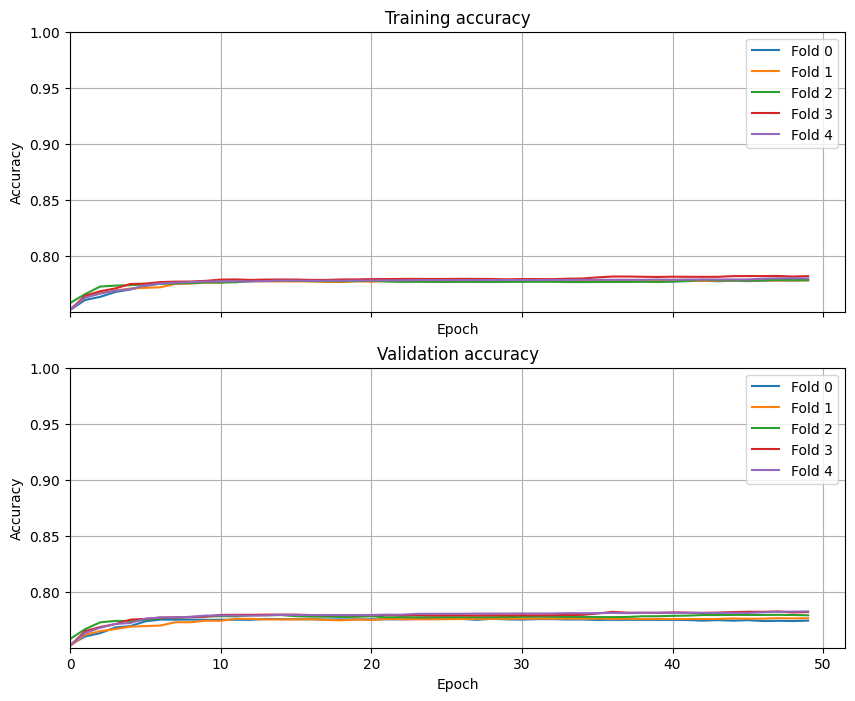

In [12]:
# Now the accuracy evolution for all folds
# Plot the loss evolution for all folds
if is_classification:
    # First the training loss
    fig = plt.figure(figsize=(10, 8))
    axes: list[Axes] = fig.subplots(2, 1, sharex=True)
    ax = axes[0]
    for i, train_accuracy_list in enumerate(train_accuracy_lists):
        ax.plot(train_accuracy_list, label=f"Fold {i}")
    ax.set_title("Training accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.set_ylim(top=1)
    ax.set_xlim(left=0)
    ax.grid()

    # Then the validation loss
    ax = axes[1]
    for i, valid_accuracy_list in enumerate(valid_accuracy_lists):
        ax.plot(valid_accuracy_list, label=f"Fold {i}")
    ax.set_title("Validation accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.set_ylim(top=1)
    ax.set_xlim(left=0)
    ax.grid()
    plt.show()

## 4. Model evaluation

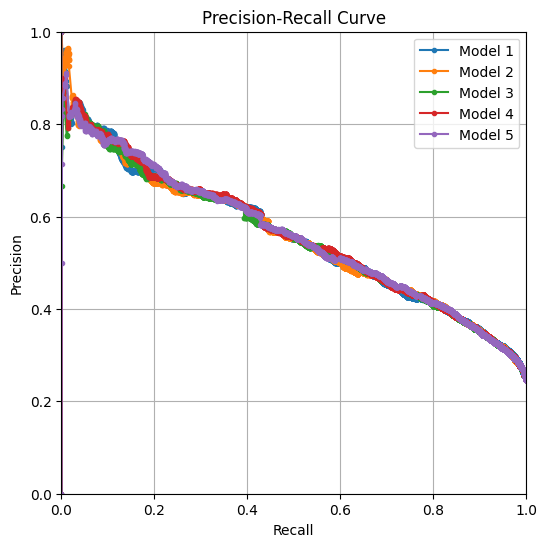

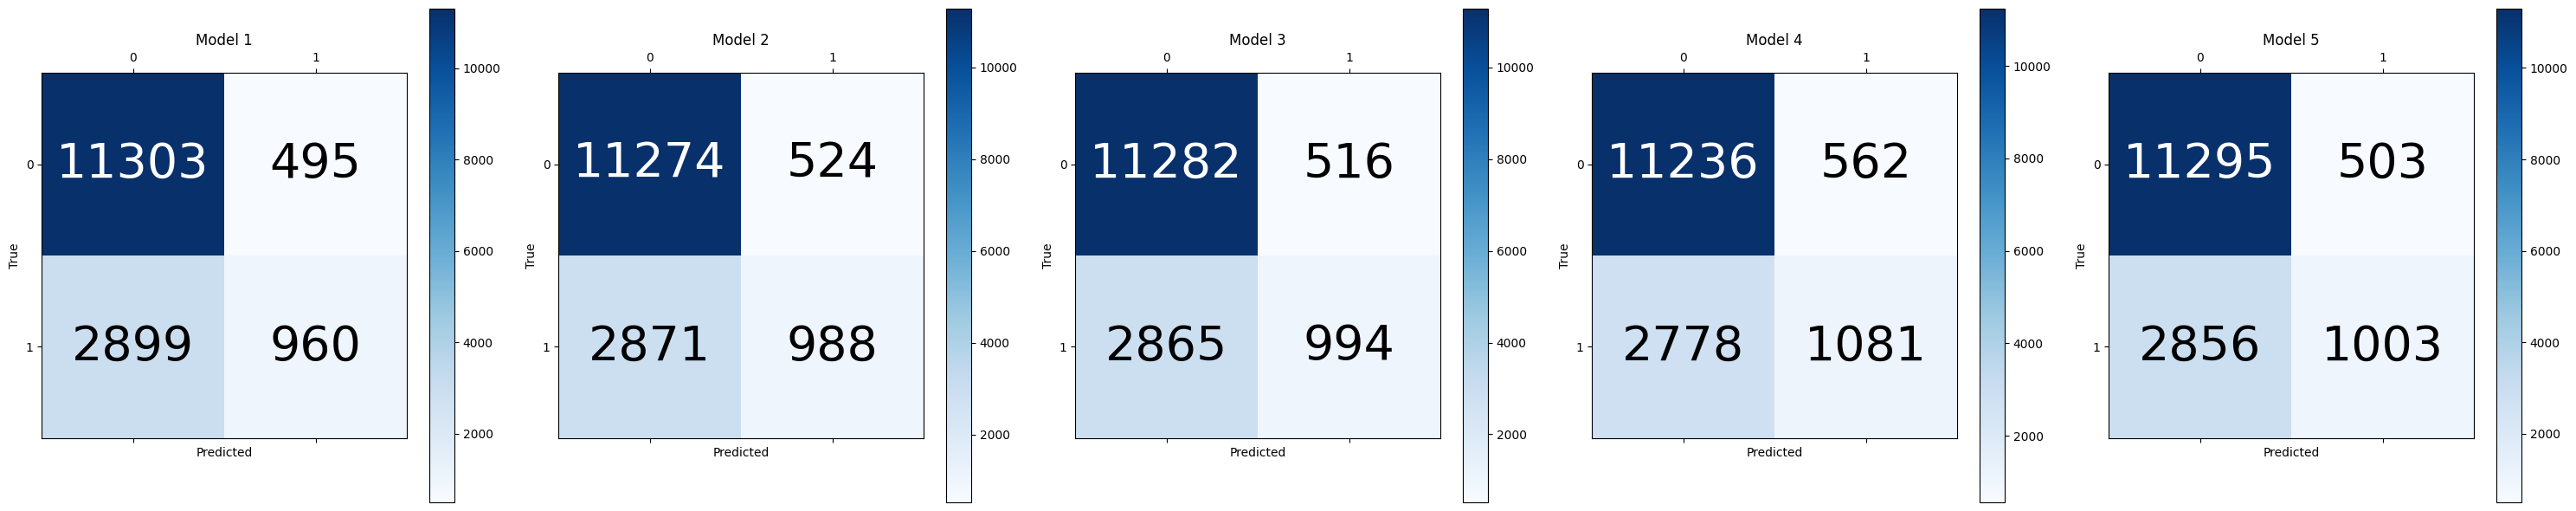

Classification Report for Model 1:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     11798
           1       0.66      0.25      0.36      3859

    accuracy                           0.78     15657
   macro avg       0.73      0.60      0.62     15657
weighted avg       0.76      0.78      0.74     15657

Classification Report for Model 2:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     11798
           1       0.65      0.26      0.37      3859

    accuracy                           0.78     15657
   macro avg       0.73      0.61      0.62     15657
weighted avg       0.76      0.78      0.75     15657

Classification Report for Model 3:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87     11798
           1       0.66      0.26      0.37      3859

    accuracy                           0.78     15657
   macro avg       0.73

In [13]:
if is_classification: 
    evaluate_models_bc(models, test_X, test_y)
else:
    evaluate_models_regression(models, test_X, test_y)

In [14]:
# select one of the models once you are happy with the results
final_model: nn.Module = models[3]

# save the model
model_scripted = torch.jit.script(final_model) # Export to TorchScript
model_scripted.save(base_folder/ "models" / "model_scripted.pt")

## 5. SHAP

In [15]:
all_X = torch.cat([train_X, test_X])[:1000]
shap_values = calculate_shap_values(final_model, all_X)

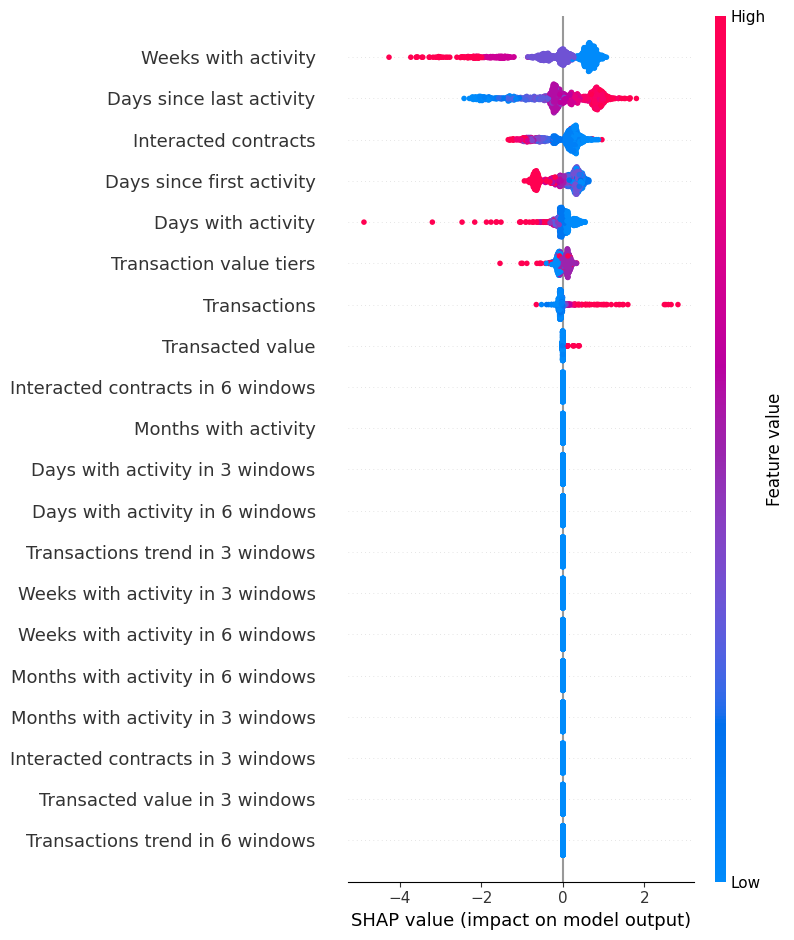

In [16]:
display_beeswarm(ModelWrapper(final_model), all_X, feature_selection, shap_values)

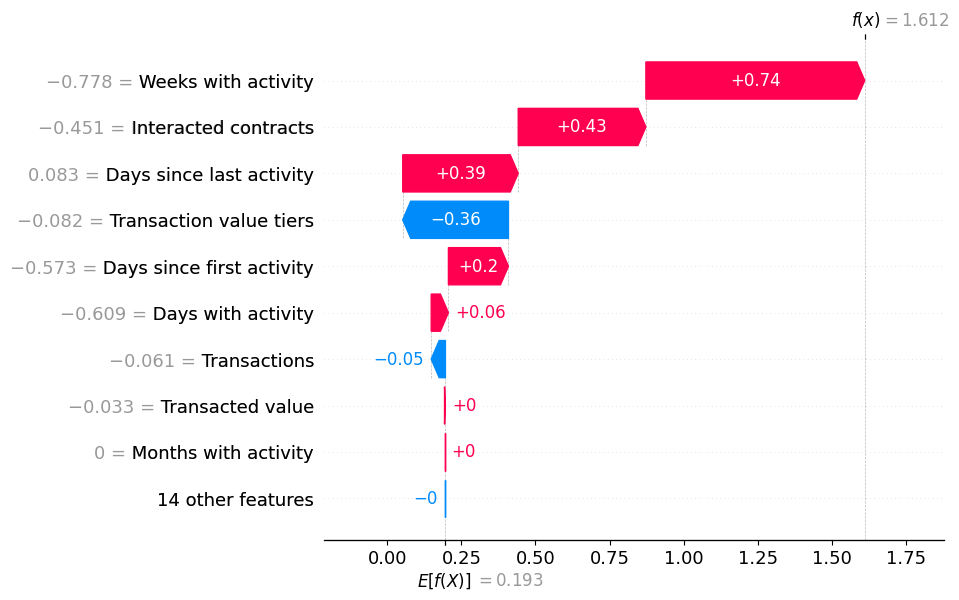

In [33]:
display_waterfall(
    shap_values,
    ModelWrapper(final_model),
    all_X,
    1,
    feature_selection,
    max_display=10,
)

## 6. ZKML model serialization

In [34]:
model_path = zkml_folder / "network.onnx"
compiled_model_path = zkml_folder / "network.ezkl"
pk_path = zkml_folder / "key.pk"
vk_path = zkml_folder / "key.vk"
settings_path = zkml_folder / "settings.json"
srs_path = zkml_folder / "kzg.srs"
witness_path = zkml_folder / "witness.json"
data_path = zkml_folder / "input_data.json"
cal_data_path = zkml_folder / "cal_data.json"
proof_path = zkml_folder / "proof.json"
proof_data_path = zkml_folder / "proof_data.json"

In [35]:
sample_input = test_X[0].reshape(1, -1)

data_array = (sample_input.detach().numpy()).reshape([-1]).tolist()

data = dict(input_data=[data_array])

# Serialize data into file:
with data_path.open("w") as f:
    json.dump(data, f)


# use the test set to calibrate the circuit
cal_data = dict(input_data=test_X.flatten().tolist())

# Serialize calibration data into file:
json.dump(data, open(cal_data_path, "w"))

In [48]:
sample_input

tensor([[-0.6088, -0.3350, -0.1383, -0.7783, -0.3903, -0.1549,  0.0000, -0.4372,
         -0.1726, -0.0342, -0.0937, -0.0478, -0.6917, -0.6760, -0.4509, -0.3288,
         -0.1379,  0.7814, -0.2561, -0.1092, -0.0785, -0.0603, -1.5977]])

In [36]:
final_model.eval()

torch.onnx.export(
    final_model,  # model being run
    sample_input,  # model input (or a tuple for multiple inputs)
    model_path,  # where to save the model (can be a file or file-like object)
    export_params=True,  # store the trained parameter weights inside the model file
    opset_version=10,  # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names=["input"],  # the model's input names
    output_names=["output"],  # the model's output names
    dynamic_axes={
        "input": {0: "batch_size"},  # variable length axes
        "output": {0: "batch_size"},
    },
)

In [37]:
# concat test_X and train_X
all_X = torch.cat((test_X, train_X), 0)

proof_input = all_X
proof_data_array = proof_input.detach().numpy().tolist()
proof_data = dict(input_data=proof_data_array)

with proof_data_path.open("w") as f:
    json.dump(proof_data, f)

In [38]:
py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "public"
py_run_args.output_visibility = "public"
py_run_args.param_visibility = "fixed" # "fixed" for params means that the committed to params are used for all proofs

res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)
assert res == True, "Failed to generate settings"

res = await ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources")
assert res == True, "Failed to calibrate settings"

In [39]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [40]:
res = ezkl.get_srs(srs_path, settings_path)

In [41]:
res = ezkl.setup(
    compiled_model_path,
    vk_path,
    pk_path,
    srs_path,
)


assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

spawning module 2
spawning module 2


In [42]:
# Generate the Witness for the proof

# now generate the witness file
res = ezkl.gen_witness(proof_data_path, compiled_model_path, witness_path)
assert witness_path.is_file()

In [43]:
# Generate the proof

proof = ezkl.prove(
    witness_path,
    compiled_model_path,
    pk_path,
    proof_path,
    srs_path,
    "single",
)

print(proof)
assert os.path.isfile(proof_path)

spawning module 2


{'instances': [[[16912579398983483403, 13419314142665758269, 16965902948054780928, 1463492787413574090], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [16912579398983483403, 13419314142665758269, 16965902948054780928, 1463492787413574090], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [0, 0, 0, 0], [16912579398983483403, 13419314142665758269, 16965902948054780928, 1463492787413574090], [10902020042510041094, 17381486299841078119, 5900175412809962030, 2475245527108272378], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [4476394681747374096, 9457141985490438420, 9584886409590048210, 451740047718875803], [16912579398983483403, 13419314142665758269, 169659029

In [44]:
# verify our proof

res = ezkl.verify(
    proof_path,
    settings_path,
    vk_path,
    srs_path,
)

assert res == True
print("verified")

verified


## 7. Generate output for backend

In [45]:
X_to_prod = transform_data(df_to_prod, feature_selection, scaler)
prod_predictions = ModelWrapper(final_model)(X_to_prod).detach().numpy().flatten()

df_final = df_to_prod.copy()
df_final["prediction"] = prod_predictions

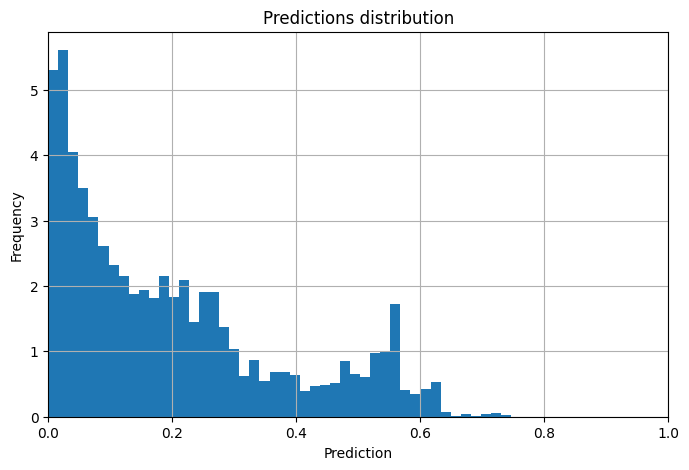

In [46]:
fig, ax = plt.subplots(figsize=(8, 5))
ax: Axes
ax.hist(df_final["prediction"], bins=50, density=True)
ax.set_title("Predictions distribution")
ax.set_xlabel("Prediction")
ax.set_ylabel("Frequency")
ax.grid()
ax.set_xlim(0, 1)

plt.show()

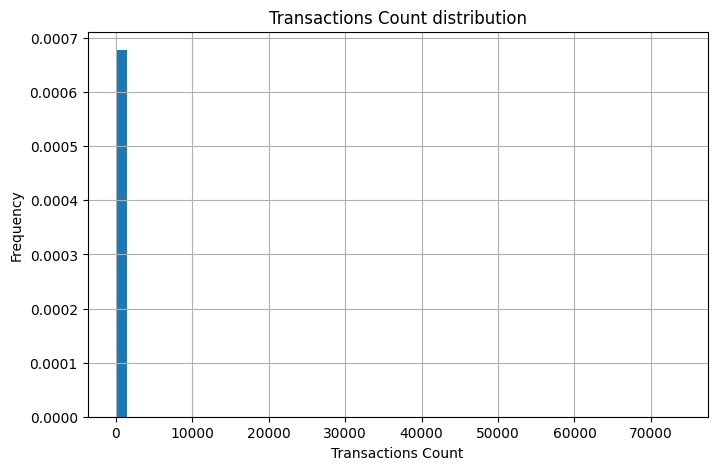

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
ax: Axes
ax.hist(df_final["Transactions"], bins=50, density=True)
ax.set_title("Transactions Count distribution")
ax.set_xlabel("Transactions Count")
ax.set_ylabel("Frequency")
ax.grid()

plt.show()

In [47]:
generate_prod_data(
    df=df_final,
    groups=[
        ("1 - 5", 1, 5),
        ("5 - 20", 5, 20),
        ("20 - 50", 20, 50),
        ("50 - 100", 50, 100),
        ("100+", 100, 10000000000),
    ],
    output_path=data_folder / "prod_data.json",
    user_col="User Address",
    prediction_col="prediction",
    value_col="Transactions",
)